In [78]:
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Dense, GRU, Conv1D, MaxPooling1D, Flatten, SimpleRNN

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

## Vader 

In [79]:
# re-reading the stock_data into pandas dataframe
stock_data = pd.read_csv('/content/drive/MyDrive/JU PROJ/Vader/Total_Tesla_stock_data.csv', index_col = False)

# renaming the column
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace = True)

# setting the column 'Date' as the index column
stock_data.set_index('Date', inplace=True)

# displaying the stock_data
stock_data

,Close,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,
2017-01-03,43.397999,0.115750,0.824875,0.059312,42.972000,44.066002,42.192001,29616500.0
2017-01-04,45.397999,0.042024,0.873762,0.084238,42.950001,45.599998,42.862000,56067500.0
2017-01-05,45.349998,0.000000,0.841500,0.158500,45.284000,45.495998,44.389999,29558500.0
2017-01-06,45.801998,0.072000,0.928000,0.000000,45.386002,46.062000,45.090000,27639500.0
2017-01-09,46.256001,0.000000,0.815000,0.185000,45.793999,46.383999,45.599998,19897500.0
...,...,...,...,...,...,...,...,...
2022-05-02,902.940002,0.045250,0.844950,0.109800,860.770020,906.359985,848.030029,25260500.0
2022-05-03,909.250000,0.024722,0.908667,0.066611,903.179993,924.080017,888.590027,21236500.0
2022-05-04,952.619995,0.044100,0.871200,0.084650,903.940002,955.500000,885.280029,27214600.0


In [80]:
stock_data = stock_data.dropna()
stock_data.isna().any()

Close       False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [81]:
stock_data= stock_data.astype({"Volume":'float'})

In [82]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1346 entries, 2017-01-03 to 2022-05-06
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     1346 non-null   float64
 1   negative  1346 non-null   float64
 2   neutral   1346 non-null   float64
 3   positive  1346 non-null   float64
 4   Open      1346 non-null   float64
 5   High      1346 non-null   float64
 6   Low       1346 non-null   float64
 7   Volume    1346 non-null   float64
dtypes: float64(8)
memory usage: 94.6+ KB


In [83]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 1076
Number of records in Test Data: 270


In [84]:
stock_data['Close_EWMA3'] = stock_data['Close'].ewm(span=3, adjust=False).mean()
stock_data['Close_EWMA7'] = stock_data['Close'].ewm(span=7, adjust=False).mean()
stock_data['Close_EWMA14'] = stock_data['Close'].ewm(span=14, adjust=False).mean()
stock_data['Close_EWMA30'] = stock_data['Close'].ewm(span=30, adjust=False).mean()

stock_data['pos_EWMA3'] = stock_data['positive'].ewm(span=3, adjust=False).mean()
stock_data['pos_EWMA7'] = stock_data['positive'].ewm(span=7, adjust=False).mean()
stock_data['pos_EWMA14'] = stock_data['positive'].ewm(span=14, adjust=False).mean()
stock_data['pos_EWMA30'] = stock_data['positive'].ewm(span=30, adjust=False).mean()

stock_data['neu_EWMA3'] = stock_data['neutral'].ewm(span=3, adjust=False).mean()
stock_data['neu_EWMA7'] = stock_data['neutral'].ewm(span=7, adjust=False).mean()
stock_data['neu_EWMA14'] = stock_data['neutral'].ewm(span=14, adjust=False).mean()
stock_data['neu_EWMA30'] = stock_data['neutral'].ewm(span=30, adjust=False).mean()

stock_data['neg_EWMA3'] = stock_data['negative'].ewm(span=3, adjust=False).mean()
stock_data['neg_EWMA7'] = stock_data['negative'].ewm(span=7, adjust=False).mean()
stock_data['neg_EWMA14'] = stock_data['negative'].ewm(span=14, adjust=False).mean()
stock_data['neg_EWMA30'] = stock_data['negative'].ewm(span=30, adjust=False).mean()

In [85]:
stock_data

,Close,negative,neutral,positive,Open,High,Low,Volume,Close_EWMA3,Close_EWMA7,...,pos_EWMA14,pos_EWMA30,neu_EWMA3,neu_EWMA7,neu_EWMA14,neu_EWMA30,neg_EWMA3,neg_EWMA7,neg_EWMA14,neg_EWMA30
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,43.397999,0.115750,0.824875,0.059312,42.972000,44.066002,42.192001,29616500.0,43.397999,43.397999,...,0.059312,0.059312,0.824875,0.824875,0.824875,0.824875,0.115750,0.115750,0.115750,0.115750
2017-01-04,45.397999,0.042024,0.873762,0.084238,42.950001,45.599998,42.862000,56067500.0,44.397999,43.897999,...,0.062636,0.060921,0.849318,0.837097,0.831393,0.828029,0.078887,0.097318,0.105920,0.110993
2017-01-05,45.349998,0.000000,0.841500,0.158500,45.284000,45.495998,44.389999,29558500.0,44.873999,44.260999,...,0.075418,0.067216,0.845409,0.838198,0.832741,0.828898,0.039443,0.072989,0.091797,0.103833
2017-01-06,45.801998,0.072000,0.928000,0.000000,45.386002,46.062000,45.090000,27639500.0,45.337998,44.646249,...,0.065362,0.062880,0.886705,0.860648,0.845442,0.835292,0.055722,0.072742,0.089158,0.101779
2017-01-09,46.256001,0.000000,0.815000,0.185000,45.793999,46.383999,45.599998,19897500.0,45.796999,45.048687,...,0.081314,0.070758,0.850852,0.849236,0.841383,0.833983,0.027861,0.054556,0.077270,0.095213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-02,902.940002,0.045250,0.844950,0.109800,860.770020,906.359985,848.030029,25260500.0,892.608051,913.037741,...,0.097224,0.094168,0.849378,0.848754,0.851100,0.855791,0.048449,0.052306,0.051665,0.050030
2022-05-03,909.250000,0.024722,0.908667,0.066611,903.179993,924.080017,888.590027,21236500.0,900.929025,912.090806,...,0.093143,0.092390,0.879022,0.863732,0.858776,0.859202,0.036586,0.045410,0.048073,0.048397
2022-05-04,952.619995,0.044100,0.871200,0.084650,903.940002,955.500000,885.280029,27214600.0,926.774510,922.223103,...,0.092010,0.091890,0.875111,0.865599,0.860432,0.859976,0.040343,0.045082,0.047543,0.048120


In [86]:
print(list(stock_data.columns.values))

['Close', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume', 'Close_EWMA3', 'Close_EWMA7', 'Close_EWMA14', 'Close_EWMA30', 'pos_EWMA3', 'pos_EWMA7', 'pos_EWMA14', 'pos_EWMA30', 'neu_EWMA3', 'neu_EWMA7', 'neu_EWMA14', 'neu_EWMA30', 'neg_EWMA3', 'neg_EWMA7', 'neg_EWMA14', 'neg_EWMA30']


In [87]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close

negative = stock_data.iloc[start:total_data,1] #neg
neutral = stock_data.iloc[start:total_data,2] #neu
positive = stock_data.iloc[start:total_data,3] #pos
open_price = stock_data.iloc[start:total_data,4] #open
high = stock_data.iloc[start:total_data,5] #high
low = stock_data.iloc[start:total_data,6] #low
volume = stock_data.iloc[start:total_data,7] #volume

ewma3_close = stock_data.iloc[start:total_data,8]#exponentially moving average 3days
ewma7_close = stock_data.iloc[start:total_data,9]#exponentially moving average 7days
ewma14_close = stock_data.iloc[start:total_data,10]#exponentially moving average 14days
ewma30_close = stock_data.iloc[start:total_data,11]#exponentially moving average 30days

ewma3_pos = stock_data.iloc[start:total_data,12]#exponentially moving average 3days
ewma7_pos = stock_data.iloc[start:total_data,13]#exponentially moving average 7days
ewma14_pos = stock_data.iloc[start:total_data,14]#exponentially moving average 14days
ewma30_pos = stock_data.iloc[start:total_data,15]#exponentially moving average 30days

ewma3_neu = stock_data.iloc[start:total_data,16]#exponentially moving average 3days
ewma7_neu = stock_data.iloc[start:total_data,17]#exponentially moving average 7days
ewma14_neu = stock_data.iloc[start:total_data,18]#exponentially moving average 14days
ewma30_neu = stock_data.iloc[start:total_data,19]#exponentially moving average 30days

ewma3_neg = stock_data.iloc[start:total_data,20]#exponentially moving average 3days
ewma7_neg = stock_data.iloc[start:total_data,21]#exponentially moving average 7days
ewma14_neg = stock_data.iloc[start:total_data,22]#exponentially moving average 14days
ewma30_neg = stock_data.iloc[start:total_data,23]#exponentially moving average 30days

In [88]:
# printing close price
print("Close Price:")
close_price

Close Price:


Date
2017-01-04     45.397999
2017-01-05     45.349998
2017-01-06     45.801998
2017-01-09     46.256001
2017-01-10     45.973999
                 ...    
2022-05-02    902.940002
2022-05-03    909.250000
2022-05-04    952.619995
2022-05-05    873.280029
2022-05-06    865.650024
Name: Close, Length: 1345, dtype: float64

In [89]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price,
                  ewma3_close,
                  ewma7_close,
                  ewma14_close,
                  ewma30_close, 
                  close_price_shifted, 

                  positive,
                  ewma3_pos,
                  ewma7_pos,
                  ewma14_pos,
                  ewma30_pos, 

                  negative,
                  ewma3_neg,
                  ewma7_neg,
                  ewma14_neg,
                  ewma30_neg,

                  neutral,
                  ewma3_neu,
                  ewma7_neu,
                  ewma14_neu,
                  ewma30_neu, 

                  volume, 
                  open_price, 
                  high, 
                  low], 
                 axis=1)
data.columns = ['close_price', 
                'ewma3_close',
                'ewma7_close',
                'ewma14_close',
                'ewma30_close',
                'close_price_shifted', 
                
                'positive', 
                'ewma3_pos',
                'ewma7_pos',
                'ewma14_pos',
                'ewma30_pos',
                
                'negative',
                'ewma3_neg',
                'ewma7_neg',
                'ewma14_neg',
                'ewma30_neg',

                'neutral', 
                'ewma3_neu',
                'ewma7_neu',
                'ewma14_neu',
                'ewma30_neu',

                'volume', 
                'open_price', 
                'high', 
                'low']
data

,close_price,ewma3_close,ewma7_close,ewma14_close,ewma30_close,close_price_shifted,positive,ewma3_pos,ewma7_pos,ewma14_pos,...,ewma30_neg,neutral,ewma3_neu,ewma7_neu,ewma14_neu,ewma30_neu,volume,open_price,high,low
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,45.397999,44.397999,43.897999,43.664665,43.527031,45.349998,0.084238,0.071775,0.065544,0.062636,...,0.110993,0.873762,0.849318,0.837097,0.831393,0.828029,56067500.0,42.950001,45.599998,42.862000
2017-01-05,45.349998,44.873999,44.260999,43.889377,43.644642,45.801998,0.158500,0.115138,0.088783,0.075418,...,0.103833,0.841500,0.845409,0.838198,0.832741,0.828898,29558500.0,45.284000,45.495998,44.389999
2017-01-06,45.801998,45.337998,44.646249,44.144393,43.783826,46.256001,0.000000,0.057569,0.066587,0.065362,...,0.101779,0.928000,0.886705,0.860648,0.845442,0.835292,27639500.0,45.386002,46.062000,45.090000
2017-01-09,46.256001,45.796999,45.048687,44.425940,43.943321,45.973999,0.185000,0.121284,0.096190,0.081314,...,0.095213,0.815000,0.850852,0.849236,0.841383,0.833983,19897500.0,45.793999,46.383999,45.599998
2017-01-10,45.973999,45.885499,45.280015,44.632348,44.074333,45.945999,0.199000,0.160142,0.121893,0.097005,...,0.095521,0.701000,0.775926,0.812177,0.822665,0.825403,18300000.0,46.400002,46.400002,45.377998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-02,902.940002,892.608051,913.037741,944.743648,961.509550,909.250000,0.109800,0.102167,0.098935,0.097224,...,0.050030,0.844950,0.849378,0.848754,0.851100,0.855791,25260500.0,860.770020,906.359985,848.030029
2022-05-03,909.250000,900.929025,912.090806,940.011162,958.137966,952.619995,0.066611,0.084389,0.090854,0.093143,...,0.048397,0.908667,0.879022,0.863732,0.858776,0.859202,21236500.0,903.179993,924.080017,888.590027
2022-05-04,952.619995,926.774510,922.223103,941.692339,957.781968,873.280029,0.084650,0.084519,0.089303,0.092010,...,0.048120,0.871200,0.875111,0.865599,0.860432,0.859976,27214600.0,903.940002,955.500000,885.280029


In [90]:
data = data.dropna()    
data

,close_price,ewma3_close,ewma7_close,ewma14_close,ewma30_close,close_price_shifted,positive,ewma3_pos,ewma7_pos,ewma14_pos,...,ewma30_neg,neutral,ewma3_neu,ewma7_neu,ewma14_neu,ewma30_neu,volume,open_price,high,low
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,45.397999,44.397999,43.897999,43.664665,43.527031,45.349998,0.084238,0.071775,0.065544,0.062636,...,0.110993,0.873762,0.849318,0.837097,0.831393,0.828029,56067500.0,42.950001,45.599998,42.862000
2017-01-05,45.349998,44.873999,44.260999,43.889377,43.644642,45.801998,0.158500,0.115138,0.088783,0.075418,...,0.103833,0.841500,0.845409,0.838198,0.832741,0.828898,29558500.0,45.284000,45.495998,44.389999
2017-01-06,45.801998,45.337998,44.646249,44.144393,43.783826,46.256001,0.000000,0.057569,0.066587,0.065362,...,0.101779,0.928000,0.886705,0.860648,0.845442,0.835292,27639500.0,45.386002,46.062000,45.090000
2017-01-09,46.256001,45.796999,45.048687,44.425940,43.943321,45.973999,0.185000,0.121284,0.096190,0.081314,...,0.095213,0.815000,0.850852,0.849236,0.841383,0.833983,19897500.0,45.793999,46.383999,45.599998
2017-01-10,45.973999,45.885499,45.280015,44.632348,44.074333,45.945999,0.199000,0.160142,0.121893,0.097005,...,0.095521,0.701000,0.775926,0.812177,0.822665,0.825403,18300000.0,46.400002,46.400002,45.377998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,870.760010,882.276100,916.403654,951.174978,965.548829,902.940002,0.097299,0.094533,0.095313,0.095290,...,0.050360,0.862606,0.853807,0.850022,0.852046,0.856538,29377700.0,902.250000,934.400024,870.000000
2022-05-02,902.940002,892.608051,913.037741,944.743648,961.509550,909.250000,0.109800,0.102167,0.098935,0.097224,...,0.050030,0.844950,0.849378,0.848754,0.851100,0.855791,25260500.0,860.770020,906.359985,848.030029
2022-05-03,909.250000,900.929025,912.090806,940.011162,958.137966,952.619995,0.066611,0.084389,0.090854,0.093143,...,0.048397,0.908667,0.879022,0.863732,0.858776,0.859202,21236500.0,903.179993,924.080017,888.590027


In [91]:
# setting the features dataset for prediction  
cols = ['close_price', 
                'ewma3_close',
                'ewma7_close',
                'ewma14_close',
                'ewma30_close',
                'close_price_shifted', 
                
                'positive', 
                'ewma3_pos',
                'ewma7_pos',
                'ewma14_pos',
                'ewma30_pos',
                
                'negative',
                'ewma3_neg',
                'ewma7_neg',
                'ewma14_neg',
                'ewma30_neg',

                'neutral', 
                'ewma3_neu',
                'ewma7_neu',
                'ewma14_neu',
                'ewma30_neu',

                'volume', 
                'open_price', 
                'high', 
                'low']
x = data[cols]
x

,close_price,ewma3_close,ewma7_close,ewma14_close,ewma30_close,close_price_shifted,positive,ewma3_pos,ewma7_pos,ewma14_pos,...,ewma30_neg,neutral,ewma3_neu,ewma7_neu,ewma14_neu,ewma30_neu,volume,open_price,high,low
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,45.397999,44.397999,43.897999,43.664665,43.527031,45.349998,0.084238,0.071775,0.065544,0.062636,...,0.110993,0.873762,0.849318,0.837097,0.831393,0.828029,56067500.0,42.950001,45.599998,42.862000
2017-01-05,45.349998,44.873999,44.260999,43.889377,43.644642,45.801998,0.158500,0.115138,0.088783,0.075418,...,0.103833,0.841500,0.845409,0.838198,0.832741,0.828898,29558500.0,45.284000,45.495998,44.389999
2017-01-06,45.801998,45.337998,44.646249,44.144393,43.783826,46.256001,0.000000,0.057569,0.066587,0.065362,...,0.101779,0.928000,0.886705,0.860648,0.845442,0.835292,27639500.0,45.386002,46.062000,45.090000
2017-01-09,46.256001,45.796999,45.048687,44.425940,43.943321,45.973999,0.185000,0.121284,0.096190,0.081314,...,0.095213,0.815000,0.850852,0.849236,0.841383,0.833983,19897500.0,45.793999,46.383999,45.599998
2017-01-10,45.973999,45.885499,45.280015,44.632348,44.074333,45.945999,0.199000,0.160142,0.121893,0.097005,...,0.095521,0.701000,0.775926,0.812177,0.822665,0.825403,18300000.0,46.400002,46.400002,45.377998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,870.760010,882.276100,916.403654,951.174978,965.548829,902.940002,0.097299,0.094533,0.095313,0.095290,...,0.050360,0.862606,0.853807,0.850022,0.852046,0.856538,29377700.0,902.250000,934.400024,870.000000
2022-05-02,902.940002,892.608051,913.037741,944.743648,961.509550,909.250000,0.109800,0.102167,0.098935,0.097224,...,0.050030,0.844950,0.849378,0.848754,0.851100,0.855791,25260500.0,860.770020,906.359985,848.030029
2022-05-03,909.250000,900.929025,912.090806,940.011162,958.137966,952.619995,0.066611,0.084389,0.090854,0.093143,...,0.048397,0.908667,0.879022,0.863732,0.858776,0.859202,21236500.0,903.179993,924.080017,888.590027


In [92]:
y = data['close_price_shifted']
y

Date
2017-01-04     45.349998
2017-01-05     45.801998
2017-01-06     46.256001
2017-01-09     45.973999
2017-01-10     45.945999
                 ...    
2022-04-29    902.940002
2022-05-02    909.250000
2022-05-03    952.619995
2022-05-04    873.280029
2022-05-05    865.650024
Name: close_price_shifted, Length: 1344, dtype: float64

In [93]:
# scaling the feature dataset
scaler_x = preprocessing.StandardScaler()
# scaling the target variable
scaler_y = preprocessing.StandardScaler()

In [94]:
x = np.array(x).reshape((len(x) ,len(cols)))
y = np.array (y).reshape ((len( y), 1))
# displaying the scaled feature dataset and the target variable
x, y

(array([[ 45.39799881,  44.39799881,  43.89799881, ...,  42.95000076,
          45.59999847,  42.86199951],
        [ 45.34999847,  44.87399864,  44.26099873, ...,  45.2840004 ,
          45.49599838,  44.38999939],
        [ 45.80199814,  45.33799839,  44.64624858, ...,  45.38600159,
          46.06200027,  45.09000015],
        ...,
        [909.25      , 900.92902549, 912.09080573, ..., 903.17999268,
         924.08001709, 888.59002686],
        [952.61999512, 926.7745103 , 922.22310307, ..., 903.94000244,
         955.5       , 885.2800293 ],
        [873.2800293 , 900.0272698 , 909.98733463, ..., 939.02001953,
         945.59997559, 857.70001221]]), array([[ 45.34999847],
        [ 45.80199814],
        [ 46.25600052],
        ...,
        [952.61999512],
        [873.2800293 ],
        [865.65002441]]))

In [95]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (1076, 25) and y: (1076, 1)
Number of rows and columns in the Test set X: (267, 25) and y: (267, 1)


In [96]:
sc = scaler_x.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

sc = scaler_y.fit(y_train)
y_train = sc.transform(y_train)
y_test = sc.transform(y_test)

In [97]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (1076, 25, 1)
Shape of Test set X: (267, 25, 1)


## Vader Model

In [98]:
import tensorflow as tf
import random 
import os

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

initializer = tf.keras.initializers.GlorotNormal()
model2=Sequential()
model2.add((LSTM(250,return_sequences=True,activation='tanh',kernel_initializer=initializer,input_shape=(len(cols),1))))
model2.add(Dropout(0.4))
model2.add(Flatten())
model2.add(Dense(1, activation = 'linear'))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 25, 250)           252000    
                                                                 
 dropout_2 (Dropout)         (None, 25, 250)           0         
                                                                 
 flatten_2 (Flatten)         (None, 6250)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 6251      
                                                                 
Total params: 258,251
Trainable params: 258,251
Non-trainable params: 0
_________________________________________________________________


In [99]:
import tensorflow as tf
model2.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
)

callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, \
    restore_best_weights=True)]

history = model2.fit(
    X_train,
    y_train,
    validation_split=0.1,
    epochs=250,
    batch_size=16,
    callbacks=callbacks,
    shuffle = False
)

Epoch 1/250
61/61 [==============================] - 7s 77ms/step - loss: 0.1263 - val_loss: 1.3768
Epoch 2/250
61/61 [==============================] - 4s 67ms/step - loss: 0.0200 - val_loss: 0.1790
Epoch 3/250
61/61 [==============================] - 4s 67ms/step - loss: 0.0105 - val_loss: 0.0434
Epoch 4/250
61/61 [==============================] - 4s 67ms/step - loss: 0.0070 - val_loss: 0.0686
Epoch 5/250
61/61 [==============================] - 5s 81ms/step - loss: 0.0072 - val_loss: 0.0548
Epoch 6/250
61/61 [==============================] - 5s 74ms/step - loss: 0.0084 - val_loss: 0.1019
Epoch 7/250
61/61 [==============================] - 4s 68ms/step - loss: 0.0077 - val_loss: 0.0467
Epoch 8/250
61/61 [==============================] - 4s 66ms/step - loss: 0.0093 - val_loss: 0.1365


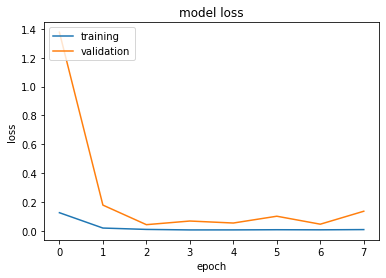

In [100]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [101]:
# performing predictions
predictions2 = model2.predict(X_test) 

# unscaling the predictions
predictions2 = scaler_y.inverse_transform(np.array(predictions2).reshape((len(predictions2), 1)))

# printing the predictions
print('Predictions:')
predictions2

Predictions:


array([[ 704.99585],
       [ 707.6401 ],
       [ 709.3924 ],
       [ 712.4164 ],
       [ 706.2712 ],
       [ 710.4748 ],
       [ 713.74567],
       [ 700.0318 ],
       [ 689.2972 ],
       [ 686.42737],
       [ 693.1974 ],
       [ 680.7396 ],
       [ 677.7103 ],
       [ 674.4401 ],
       [ 676.93115],
       [ 670.932  ],
       [ 657.04736],
       [ 648.52014],
       [ 628.13257],
       [ 618.1011 ],
       [ 611.39624],
       [ 598.9093 ],
       [ 598.34436],
       [ 589.1031 ],
       [ 600.8731 ],
       [ 591.81396],
       [ 609.0439 ],
       [ 606.7735 ],
       [ 619.2226 ],
       [ 623.36676],
       [ 623.2517 ],
       [ 617.2884 ],
       [ 609.24536],
       [ 599.2567 ],
       [ 599.635  ],
       [ 602.1993 ],
       [ 607.77844],
       [ 602.00793],
       [ 601.64764],
       [ 603.37714],
       [ 604.27423],
       [ 602.6097 ],
       [ 602.1806 ],
       [ 605.5664 ],
       [ 611.7655 ],
       [ 615.2131 ],
       [ 619.6513 ],
       [ 636.

## Finbert

In [102]:
# re-reading the stock_data into pandas dataframe
stock_data = pd.read_csv('/content/drive/MyDrive/JU PROJ/TSLA FinBERT/TOTAL_FINBERT_Tesla_stock_data.csv', index_col = False)

# renaming the column
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace = True)

# setting the column 'Date' as the index column
stock_data.set_index('Date', inplace=True)

# displaying the stock_data
stock_data.head()

,Close,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,
2017-01-03,43.397999,0.150608,0.209587,0.639805,42.972000,44.066002,42.192001,29616500.0
2017-01-04,45.397999,0.173676,0.187838,0.638485,42.950001,45.599998,42.862000,56067500.0
2017-01-05,45.349998,0.115238,0.162271,0.722491,45.284000,45.495998,44.389999,29558500.0
2017-01-06,45.801998,0.143946,0.211864,0.644191,45.386002,46.062000,45.090000,27639500.0
2017-01-09,46.256001,0.092892,0.182005,0.725102,45.793999,46.383999,45.599998,19897500.0


In [103]:
stock_data.shape

(1346, 8)

In [104]:
stock_data.isna().any()

Close       False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [105]:
stock_data = stock_data.dropna()

In [106]:
stock_data.isna().any()

Close       False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [107]:
stock_data.describe(include='all')

,Close,negative,neutral,positive,Open,High,Low,Volume
count,1346.000000,1346.000000,1346.000000,1346.000000,1346.000000,1346.000000,1346.000000,1.346000e+03
mean,295.546675,0.135288,0.173204,0.691508,295.573306,302.247606,288.313605,4.351325e+07
std,336.618073,0.101520,0.118294,0.136007,336.945344,344.687318,328.204762,2.958215e+07
min,35.793999,0.011124,0.009788,0.039601,36.220001,37.335999,35.397999,9.800600e+06
25%,60.522501,0.071582,0.086735,0.620725,60.400002,61.504500,59.273000,2.458988e+07
50%,70.862000,0.107078,0.163549,0.709822,70.875000,71.915001,69.917000,3.421775e+07
75%,606.112503,0.165091,0.227628,0.777604,604.659988,621.204971,595.574982,5.067100e+07
max,1229.910034,0.916332,0.949275,0.947868,1234.410034,1243.489990,1217.000000,3.046940e+08


In [108]:
stock_data= stock_data.astype({"Volume":'float'})

In [109]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1346 entries, 2017-01-03 to 2022-05-06
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     1346 non-null   float64
 1   negative  1346 non-null   float64
 2   neutral   1346 non-null   float64
 3   positive  1346 non-null   float64
 4   Open      1346 non-null   float64
 5   High      1346 non-null   float64
 6   Low       1346 non-null   float64
 7   Volume    1346 non-null   float64
dtypes: float64(8)
memory usage: 94.6+ KB


In [110]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 1076
Number of records in Test Data: 270


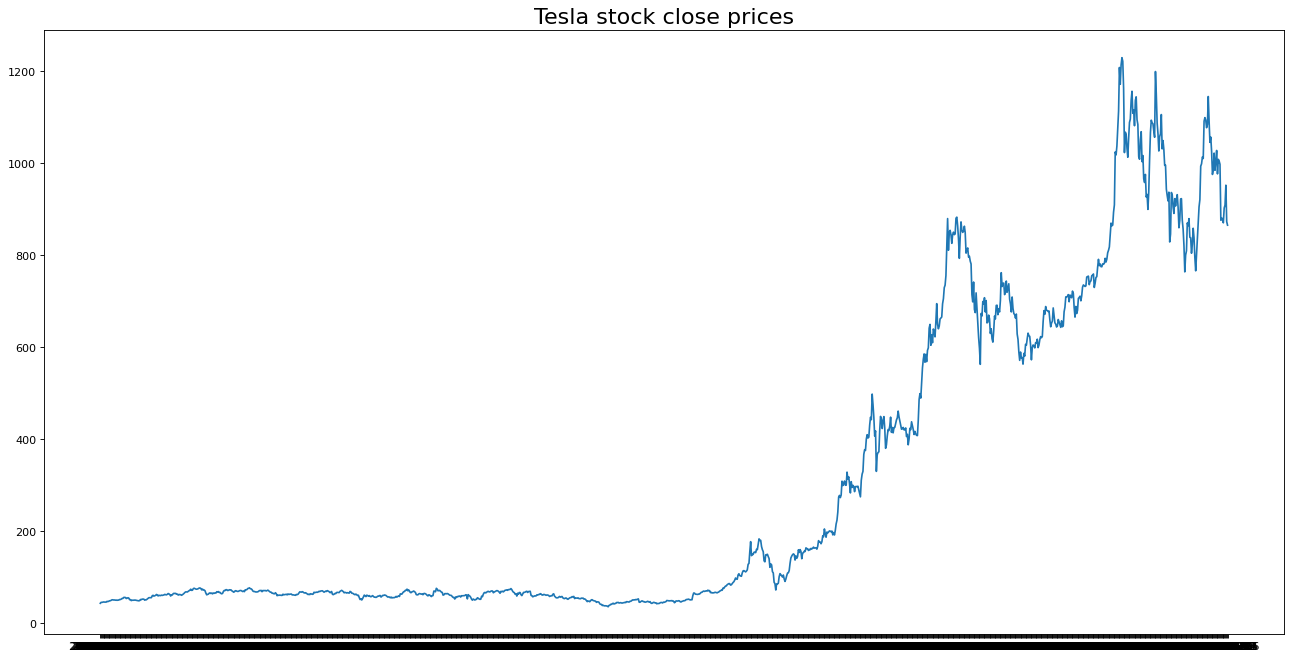

In [111]:
plt.figure(figsize=(20, 10), dpi=80)
plt.title('Tesla stock close prices', size=20)
plt.plot(stock_data['Close'])
plt.show()

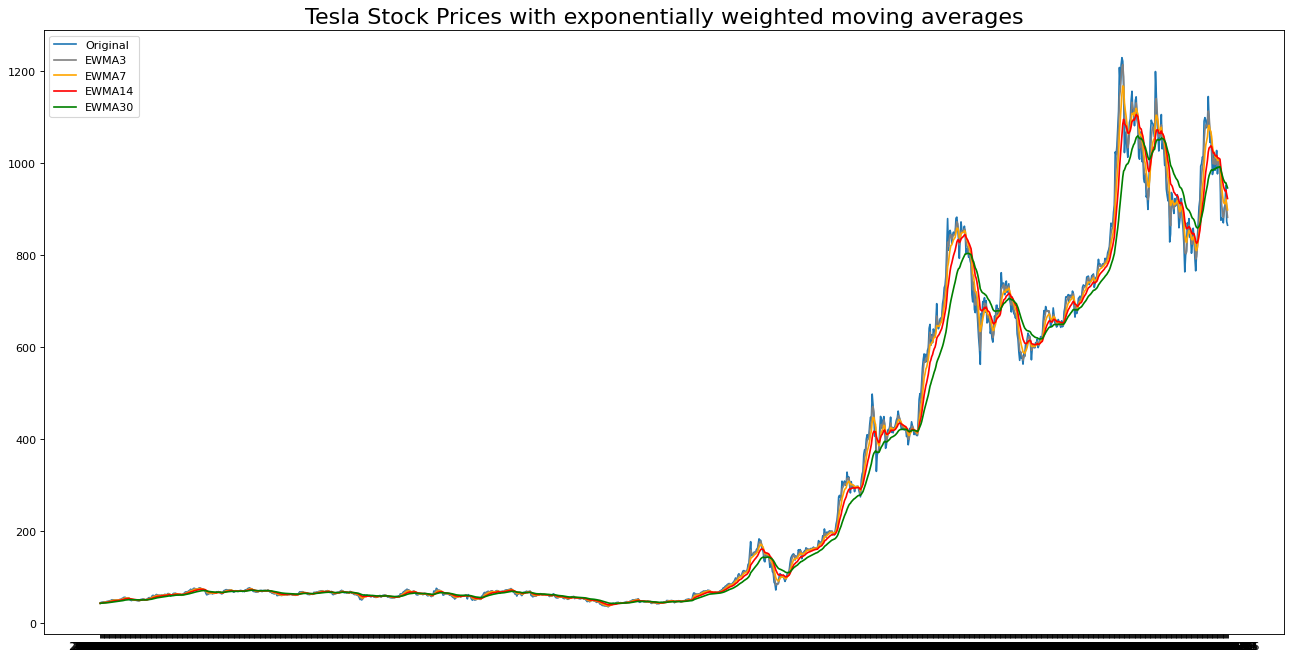

In [112]:
stock_data['Close_EWMA3'] = stock_data['Close'].ewm(span=3, adjust=False).mean()
stock_data['Close_EWMA7'] = stock_data['Close'].ewm(span=7, adjust=False).mean()
stock_data['Close_EWMA14'] = stock_data['Close'].ewm(span=14, adjust=False).mean()
stock_data['Close_EWMA30'] = stock_data['Close'].ewm(span=30, adjust=False).mean()

stock_data['pos_EWMA3'] = stock_data['positive'].ewm(span=3, adjust=False).mean()
stock_data['pos_EWMA7'] = stock_data['positive'].ewm(span=7, adjust=False).mean()
stock_data['pos_EWMA14'] = stock_data['positive'].ewm(span=14, adjust=False).mean()
stock_data['pos_EWMA30'] = stock_data['positive'].ewm(span=30, adjust=False).mean()

stock_data['neu_EWMA3'] = stock_data['neutral'].ewm(span=3, adjust=False).mean()
stock_data['neu_EWMA7'] = stock_data['neutral'].ewm(span=7, adjust=False).mean()
stock_data['neu_EWMA14'] = stock_data['neutral'].ewm(span=14, adjust=False).mean()
stock_data['neu_EWMA30'] = stock_data['neutral'].ewm(span=30, adjust=False).mean()

stock_data['neg_EWMA3'] = stock_data['negative'].ewm(span=3, adjust=False).mean()
stock_data['neg_EWMA7'] = stock_data['negative'].ewm(span=7, adjust=False).mean()
stock_data['neg_EWMA14'] = stock_data['negative'].ewm(span=14, adjust=False).mean()
stock_data['neg_EWMA30'] = stock_data['negative'].ewm(span=30, adjust=False).mean()

# Plot
plt.figure(figsize=(20, 10), dpi=80)
plt.title('Tesla Stock Prices with exponentially weighted moving averages', size=20)
plt.plot(stock_data['Close'], label='Original')
plt.plot(stock_data['Close_EWMA3'], color='gray', label='EWMA3')
plt.plot(stock_data['Close_EWMA7'], color='orange', label='EWMA7')
plt.plot(stock_data['Close_EWMA14'], color='red', label='EWMA14')
plt.plot(stock_data['Close_EWMA30'], color='green', label='EWMA30')

plt.legend();

In [113]:
stock_data

,Close,negative,neutral,positive,Open,High,Low,Volume,Close_EWMA3,Close_EWMA7,...,pos_EWMA14,pos_EWMA30,neu_EWMA3,neu_EWMA7,neu_EWMA14,neu_EWMA30,neg_EWMA3,neg_EWMA7,neg_EWMA14,neg_EWMA30
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,43.397999,0.150608,0.209587,0.639805,42.972000,44.066002,42.192001,29616500.0,43.397999,43.397999,...,0.639805,0.639805,0.209587,0.209587,0.209587,0.209587,0.150608,0.150608,0.150608,0.150608
2017-01-04,45.397999,0.173676,0.187838,0.638485,42.950001,45.599998,42.862000,56067500.0,44.397999,43.897999,...,0.639629,0.639720,0.198713,0.204150,0.206687,0.208184,0.162142,0.156375,0.153684,0.152096
2017-01-05,45.349998,0.115238,0.162271,0.722491,45.284000,45.495998,44.389999,29558500.0,44.873999,44.260999,...,0.650678,0.645060,0.180492,0.193680,0.200765,0.205222,0.138690,0.146091,0.148558,0.149718
2017-01-06,45.801998,0.143946,0.211864,0.644191,45.386002,46.062000,45.090000,27639500.0,45.337998,44.646249,...,0.649813,0.645004,0.196178,0.198226,0.202245,0.205650,0.141318,0.145554,0.147943,0.149346
2017-01-09,46.256001,0.092892,0.182005,0.725102,45.793999,46.383999,45.599998,19897500.0,45.796999,45.048687,...,0.659851,0.650172,0.189092,0.194171,0.199546,0.204125,0.117105,0.132389,0.140603,0.145704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-02,902.940002,0.106230,0.211320,0.682450,860.770020,906.359985,848.030029,25260500.0,892.608051,913.037741,...,0.701668,0.716582,0.212969,0.196035,0.172759,0.164380,0.108717,0.121206,0.125573,0.119038
2022-05-03,909.250000,0.106230,0.211320,0.682450,903.179993,924.080017,888.590027,21236500.0,900.929025,912.090806,...,0.699105,0.714380,0.212145,0.199856,0.177901,0.167409,0.107474,0.117462,0.122994,0.118212
2022-05-04,952.619995,0.106230,0.211320,0.682450,903.940002,955.500000,885.280029,27214600.0,926.774510,922.223103,...,0.696884,0.712320,0.211732,0.202722,0.182357,0.170242,0.106852,0.114654,0.120759,0.117439


In [114]:
print(list(stock_data.columns.values))

['Close', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume', 'Close_EWMA3', 'Close_EWMA7', 'Close_EWMA14', 'Close_EWMA30', 'pos_EWMA3', 'pos_EWMA7', 'pos_EWMA14', 'pos_EWMA30', 'neu_EWMA3', 'neu_EWMA7', 'neu_EWMA14', 'neu_EWMA30', 'neg_EWMA3', 'neg_EWMA7', 'neg_EWMA14', 'neg_EWMA30']


In [115]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close

negative = stock_data.iloc[start:total_data,1] #neg
neutral = stock_data.iloc[start:total_data,2] #neu
positive = stock_data.iloc[start:total_data,3] #pos
open_price = stock_data.iloc[start:total_data,4] #open
high = stock_data.iloc[start:total_data,5] #high
low = stock_data.iloc[start:total_data,6] #low
volume = stock_data.iloc[start:total_data,7] #volume

ewma3_close = stock_data.iloc[start:total_data,8]#exponentially moving average 3days
ewma7_close = stock_data.iloc[start:total_data,9]#exponentially moving average 7days
ewma14_close = stock_data.iloc[start:total_data,10]#exponentially moving average 14days
ewma30_close = stock_data.iloc[start:total_data,11]#exponentially moving average 30days

ewma3_pos = stock_data.iloc[start:total_data,12]#exponentially moving average 3days
ewma7_pos = stock_data.iloc[start:total_data,13]#exponentially moving average 7days
ewma14_pos = stock_data.iloc[start:total_data,14]#exponentially moving average 14days
ewma30_pos = stock_data.iloc[start:total_data,15]#exponentially moving average 30days

ewma3_neu = stock_data.iloc[start:total_data,16]#exponentially moving average 3days
ewma7_neu = stock_data.iloc[start:total_data,17]#exponentially moving average 7days
ewma14_neu = stock_data.iloc[start:total_data,18]#exponentially moving average 14days
ewma30_neu = stock_data.iloc[start:total_data,19]#exponentially moving average 30days

ewma3_neg = stock_data.iloc[start:total_data,20]#exponentially moving average 3days
ewma7_neg = stock_data.iloc[start:total_data,21]#exponentially moving average 7days
ewma14_neg = stock_data.iloc[start:total_data,22]#exponentially moving average 14days
ewma30_neg = stock_data.iloc[start:total_data,23]#exponentially moving average 30days

In [116]:
# printing close price
print("Close Price:")
close_price

Close Price:


Date
2017-01-04     45.397999
2017-01-05     45.349998
2017-01-06     45.801998
2017-01-09     46.256001
2017-01-10     45.973999
                 ...    
2022-05-02    902.940002
2022-05-03    909.250000
2022-05-04    952.619995
2022-05-05    873.280029
2022-05-06    865.650024
Name: Close, Length: 1345, dtype: float64

In [117]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price,
                  ewma3_close,
                  ewma7_close,
                  ewma14_close,
                  ewma30_close, 
                  close_price_shifted, 

                  positive,
                  ewma3_pos,
                  ewma7_pos,
                  ewma14_pos,
                  ewma30_pos, 

                  negative,
                  ewma3_neg,
                  ewma7_neg,
                  ewma14_neg,
                  ewma30_neg,

                  neutral,
                  ewma3_neu,
                  ewma7_neu,
                  ewma14_neu,
                  ewma30_neu, 

                  volume, 
                  open_price, 
                  high, 
                  low], 
                 axis=1)
data.columns = ['close_price', 
                'ewma3_close',
                'ewma7_close',
                'ewma14_close',
                'ewma30_close',
                'close_price_shifted', 
                
                'positive', 
                'ewma3_pos',
                'ewma7_pos',
                'ewma14_pos',
                'ewma30_pos',
                
                'negative',
                'ewma3_neg',
                'ewma7_neg',
                'ewma14_neg',
                'ewma30_neg',

                'neutral', 
                'ewma3_neu',
                'ewma7_neu',
                'ewma14_neu',
                'ewma30_neu',

                'volume', 
                'open_price', 
                'high', 
                'low']
data

,close_price,ewma3_close,ewma7_close,ewma14_close,ewma30_close,close_price_shifted,positive,ewma3_pos,ewma7_pos,ewma14_pos,...,ewma30_neg,neutral,ewma3_neu,ewma7_neu,ewma14_neu,ewma30_neu,volume,open_price,high,low
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,45.397999,44.397999,43.897999,43.664665,43.527031,45.349998,0.638485,0.639145,0.639475,0.639629,...,0.152096,0.187838,0.198713,0.204150,0.206687,0.208184,56067500.0,42.950001,45.599998,42.862000
2017-01-05,45.349998,44.873999,44.260999,43.889377,43.644642,45.801998,0.722491,0.680818,0.660229,0.650678,...,0.149718,0.162271,0.180492,0.193680,0.200765,0.205222,29558500.0,45.284000,45.495998,44.389999
2017-01-06,45.801998,45.337998,44.646249,44.144393,43.783826,46.256001,0.644191,0.662505,0.656220,0.649813,...,0.149346,0.211864,0.196178,0.198226,0.202245,0.205650,27639500.0,45.386002,46.062000,45.090000
2017-01-09,46.256001,45.796999,45.048687,44.425940,43.943321,45.973999,0.725102,0.693803,0.673440,0.659851,...,0.145704,0.182005,0.189092,0.194171,0.199546,0.204125,19897500.0,45.793999,46.383999,45.599998
2017-01-10,45.973999,45.885499,45.280015,44.632348,44.074333,45.945999,0.725102,0.709453,0.686356,0.668551,...,0.142296,0.182005,0.185548,0.191129,0.197207,0.202698,18300000.0,46.400002,46.400002,45.377998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-02,902.940002,892.608051,913.037741,944.743648,961.509550,909.250000,0.682450,0.678314,0.682759,0.701668,...,0.119038,0.211320,0.212969,0.196035,0.172759,0.164380,25260500.0,860.770020,906.359985,848.030029
2022-05-03,909.250000,900.929025,912.090806,940.011162,958.137966,952.619995,0.682450,0.680382,0.682682,0.699105,...,0.118212,0.211320,0.212145,0.199856,0.177901,0.167409,21236500.0,903.179993,924.080017,888.590027
2022-05-04,952.619995,926.774510,922.223103,941.692339,957.781968,873.280029,0.682450,0.681416,0.682624,0.696884,...,0.117439,0.211320,0.211732,0.202722,0.182357,0.170242,27214600.0,903.940002,955.500000,885.280029


In [118]:
data = data.dropna()    
data.head(10)

,close_price,ewma3_close,ewma7_close,ewma14_close,ewma30_close,close_price_shifted,positive,ewma3_pos,ewma7_pos,ewma14_pos,...,ewma30_neg,neutral,ewma3_neu,ewma7_neu,ewma14_neu,ewma30_neu,volume,open_price,high,low
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,45.397999,44.397999,43.897999,43.664665,43.527031,45.349998,0.638485,0.639145,0.639475,0.639629,...,0.152096,0.187838,0.198713,0.204150,0.206687,0.208184,56067500.0,42.950001,45.599998,42.862000
2017-01-05,45.349998,44.873999,44.260999,43.889377,43.644642,45.801998,0.722491,0.680818,0.660229,0.650678,...,0.149718,0.162271,0.180492,0.193680,0.200765,0.205222,29558500.0,45.284000,45.495998,44.389999
2017-01-06,45.801998,45.337998,44.646249,44.144393,43.783826,46.256001,0.644191,0.662505,0.656220,0.649813,...,0.149346,0.211864,0.196178,0.198226,0.202245,0.205650,27639500.0,45.386002,46.062000,45.090000
2017-01-09,46.256001,45.796999,45.048687,44.425940,43.943321,45.973999,0.725102,0.693803,0.673440,0.659851,...,0.145704,0.182005,0.189092,0.194171,0.199546,0.204125,19897500.0,45.793999,46.383999,45.599998
2017-01-10,45.973999,45.885499,45.280015,44.632348,44.074333,45.945999,0.725102,0.709453,0.686356,0.668551,...,0.142296,0.182005,0.185548,0.191129,0.197207,0.202698,18300000.0,46.400002,46.400002,45.377998
2017-01-11,45.945999,45.915749,45.446511,44.807502,44.195085,45.917999,0.725102,0.717278,0.696042,0.676092,...,0.139109,0.182005,0.183777,0.188848,0.195180,0.201363,18254000.0,45.813999,45.995998,45.335999
2017-01-12,45.917999,45.916874,45.564383,44.955568,44.306241,47.549999,0.725102,0.721190,0.703307,0.682626,...,0.136127,0.182005,0.182891,0.187138,0.193424,0.200114,18951000.0,45.812000,46.139999,45.116001
2017-01-13,47.549999,46.733437,46.060787,45.301492,44.515516,47.116001,0.725102,0.723146,0.708756,0.688290,...,0.133338,0.182005,0.182448,0.185855,0.191901,0.198945,30465000.0,46.000000,47.570000,45.917999
2017-01-17,47.116001,46.924719,46.324591,45.543427,44.683289,47.672001,0.363746,0.543446,0.622504,0.645017,...,0.146980,0.291457,0.236953,0.212255,0.205175,0.204914,23087500.0,47.340000,47.992001,46.874001


In [119]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

Date
2017-01-04     45.349998
2017-01-05     45.801998
2017-01-06     46.256001
2017-01-09     45.973999
2017-01-10     45.945999
                 ...    
2022-04-29    902.940002
2022-05-02    909.250000
2022-05-03    952.619995
2022-05-04    873.280029
2022-05-05    865.650024
Name: close_price_shifted, Length: 1344, dtype: float64

In [120]:
# setting the features dataset for prediction  
cols = ['close_price', 
                'ewma3_close',
                'ewma7_close',
                'ewma14_close',
                'ewma30_close',
                'close_price_shifted', 
                
                'positive', 
                'ewma3_pos',
                'ewma7_pos',
                'ewma14_pos',
                'ewma30_pos',
                
                'negative',
                'ewma3_neg',
                'ewma7_neg',
                'ewma14_neg',
                'ewma30_neg',

                'neutral', 
                'ewma3_neu',
                'ewma7_neu',
                'ewma14_neu',
                'ewma30_neu',

                'volume', 
                'open_price', 
                'high', 
                'low']
x = data[cols]
x

,close_price,ewma3_close,ewma7_close,ewma14_close,ewma30_close,close_price_shifted,positive,ewma3_pos,ewma7_pos,ewma14_pos,...,ewma30_neg,neutral,ewma3_neu,ewma7_neu,ewma14_neu,ewma30_neu,volume,open_price,high,low
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,45.397999,44.397999,43.897999,43.664665,43.527031,45.349998,0.638485,0.639145,0.639475,0.639629,...,0.152096,0.187838,0.198713,0.204150,0.206687,0.208184,56067500.0,42.950001,45.599998,42.862000
2017-01-05,45.349998,44.873999,44.260999,43.889377,43.644642,45.801998,0.722491,0.680818,0.660229,0.650678,...,0.149718,0.162271,0.180492,0.193680,0.200765,0.205222,29558500.0,45.284000,45.495998,44.389999
2017-01-06,45.801998,45.337998,44.646249,44.144393,43.783826,46.256001,0.644191,0.662505,0.656220,0.649813,...,0.149346,0.211864,0.196178,0.198226,0.202245,0.205650,27639500.0,45.386002,46.062000,45.090000
2017-01-09,46.256001,45.796999,45.048687,44.425940,43.943321,45.973999,0.725102,0.693803,0.673440,0.659851,...,0.145704,0.182005,0.189092,0.194171,0.199546,0.204125,19897500.0,45.793999,46.383999,45.599998
2017-01-10,45.973999,45.885499,45.280015,44.632348,44.074333,45.945999,0.725102,0.709453,0.686356,0.668551,...,0.142296,0.182005,0.185548,0.191129,0.197207,0.202698,18300000.0,46.400002,46.400002,45.377998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,870.760010,882.276100,916.403654,951.174978,965.548829,902.940002,0.675729,0.674178,0.682862,0.704624,...,0.119921,0.218424,0.214617,0.190940,0.166827,0.161143,29377700.0,902.250000,934.400024,870.000000
2022-05-02,902.940002,892.608051,913.037741,944.743648,961.509550,909.250000,0.682450,0.678314,0.682759,0.701668,...,0.119038,0.211320,0.212969,0.196035,0.172759,0.164380,25260500.0,860.770020,906.359985,848.030029
2022-05-03,909.250000,900.929025,912.090806,940.011162,958.137966,952.619995,0.682450,0.680382,0.682682,0.699105,...,0.118212,0.211320,0.212145,0.199856,0.177901,0.167409,21236500.0,903.179993,924.080017,888.590027


In [121]:
from sklearn.preprocessing import StandardScaler
# scaling the feature dataset

scaler_x = preprocessing.StandardScaler ()
x = np.array(x).reshape((len(x) ,len(cols)))
# scaling the target variable
scaler_y = preprocessing.StandardScaler ()
y = np.array (y).reshape ((len( y), 1))
# displaying the scaled feature dataset and the target variable
x, y

(array([[ 45.39799881,  44.39799881,  43.89799881, ...,  42.95000076,
          45.59999847,  42.86199951],
        [ 45.34999847,  44.87399864,  44.26099873, ...,  45.2840004 ,
          45.49599838,  44.38999939],
        [ 45.80199814,  45.33799839,  44.64624858, ...,  45.38600159,
          46.06200027,  45.09000015],
        ...,
        [909.25      , 900.92902549, 912.09080573, ..., 903.17999268,
         924.08001709, 888.59002686],
        [952.61999512, 926.7745103 , 922.22310307, ..., 903.94000244,
         955.5       , 885.2800293 ],
        [873.2800293 , 900.0272698 , 909.98733463, ..., 939.02001953,
         945.59997559, 857.70001221]]), array([[ 45.34999847],
        [ 45.80199814],
        [ 46.25600052],
        ...,
        [952.61999512],
        [873.2800293 ],
        [865.65002441]]))

In [122]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (1076, 25) and y: (1076, 1)
Number of rows and columns in the Test set X: (267, 25) and y: (267, 1)


In [123]:
sc = scaler_x.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

sc = scaler_y.fit(y_train)
y_train = sc.transform(y_train)
y_test = sc.transform(y_test)

In [124]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (1076, 25, 1)
Shape of Test set X: (267, 25, 1)


## Finbert Model

In [125]:
import tensorflow as tf
import random 

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

initializer = tf.keras.initializers.GlorotNormal()
model1=Sequential()
model1.add((LSTM(250,return_sequences=True,activation='tanh',kernel_initializer=initializer,input_shape=(len(cols),1))))
model1.add(Dropout(0.4))
model1.add(Flatten())
model1.add(Dense(1, activation = 'linear'))
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 25, 250)           252000    
                                                                 
 dropout_3 (Dropout)         (None, 25, 250)           0         
                                                                 
 flatten_3 (Flatten)         (None, 6250)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6251      
                                                                 
Total params: 258,251
Trainable params: 258,251
Non-trainable params: 0
_________________________________________________________________


In [126]:
import tensorflow as tf
model1.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
)

callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, \
    restore_best_weights=True)]

history = model1.fit(
    X_train,
    y_train,
    validation_split=0.1,
    epochs=250,
    batch_size=16,
    callbacks=callbacks,
    shuffle = False
)

Epoch 1/250
61/61 [==============================] - 6s 72ms/step - loss: 0.1186 - val_loss: 1.3095
Epoch 2/250
61/61 [==============================] - 4s 60ms/step - loss: 0.0081 - val_loss: 0.0427
Epoch 3/250
61/61 [==============================] - 4s 62ms/step - loss: 0.0060 - val_loss: 0.0370
Epoch 4/250
61/61 [==============================] - 4s 70ms/step - loss: 0.0063 - val_loss: 0.0368
Epoch 5/250
61/61 [==============================] - 4s 64ms/step - loss: 0.0071 - val_loss: 0.0756
Epoch 6/250
61/61 [==============================] - 4s 66ms/step - loss: 0.0116 - val_loss: 0.1444
Epoch 7/250
61/61 [==============================] - 4s 67ms/step - loss: 0.0102 - val_loss: 0.0542
Epoch 8/250
61/61 [==============================] - 4s 65ms/step - loss: 0.0140 - val_loss: 0.2895
Epoch 9/250
61/61 [==============================] - 4s 63ms/step - loss: 0.0074 - val_loss: 0.0323
Epoch 10/250
61/61 [==============================] - 4s 61ms/step - loss: 0.0058 - val_loss: 0.1013

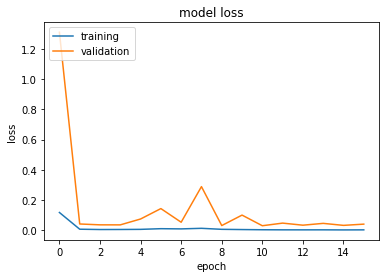

In [127]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [128]:
# performing predictions
predictions1 = model1.predict(X_test) 

# unscaling the predictions
predictions1 = scaler_y.inverse_transform(np.array(predictions1).reshape((len(predictions1), 1)))

# printing the predictions
print('Predictions:')
predictions1

Predictions:


array([[ 726.01135],
       [ 718.4033 ],
       [ 722.3301 ],
       [ 725.7814 ],
       [ 723.42065],
       [ 721.0481 ],
       [ 727.11395],
       [ 714.98145],
       [ 705.6897 ],
       [ 701.068  ],
       [ 705.6703 ],
       [ 697.0998 ],
       [ 691.83105],
       [ 691.5818 ],
       [ 686.862  ],
       [ 681.52496],
       [ 665.0734 ],
       [ 652.0006 ],
       [ 635.1702 ],
       [ 626.1959 ],
       [ 622.96783],
       [ 615.5648 ],
       [ 611.9621 ],
       [ 605.814  ],
       [ 609.9458 ],
       [ 610.6524 ],
       [ 618.8812 ],
       [ 621.5659 ],
       [ 629.09076],
       [ 634.2487 ],
       [ 634.3029 ],
       [ 631.5387 ],
       [ 622.3697 ],
       [ 612.4697 ],
       [ 615.3974 ],
       [ 617.3634 ],
       [ 618.8865 ],
       [ 615.80286],
       [ 619.7648 ],
       [ 619.9578 ],
       [ 618.1755 ],
       [ 615.4224 ],
       [ 613.16077],
       [ 616.9756 ],
       [ 623.85284],
       [ 621.0436 ],
       [ 623.8417 ],
       [ 639.

## Unscaling

In [129]:
# unscaling the test feature dataset, x_test
# unscaling the test y dataset, y_test+
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

## MODEL COMPARISION

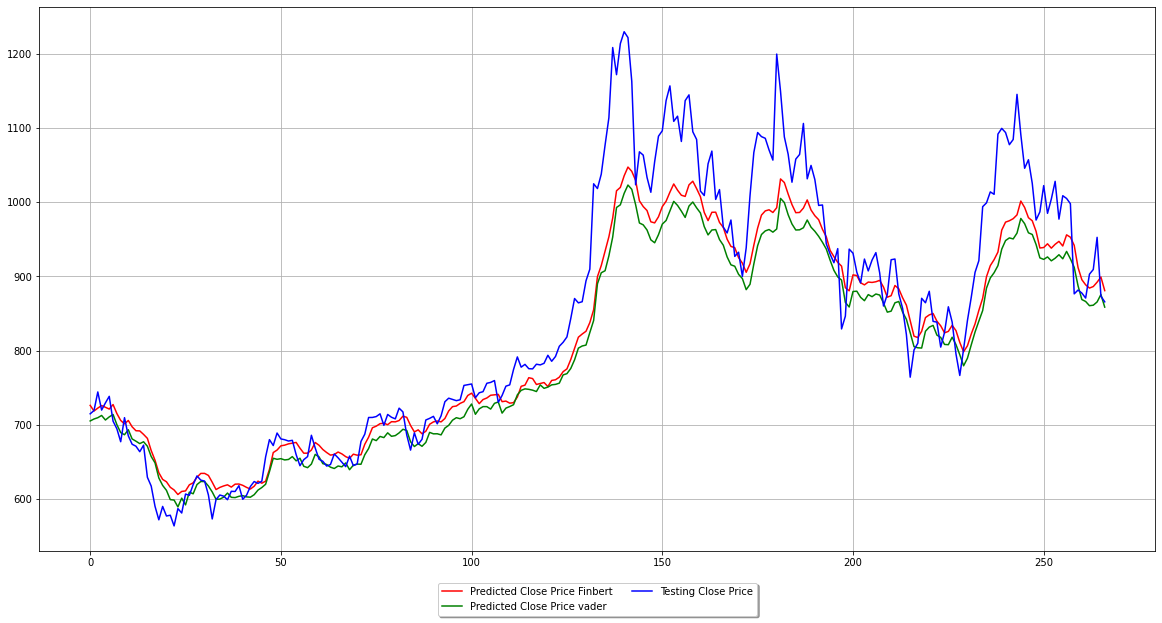

In [130]:

plt.figure(figsize=(20,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions1,'-r', label="Predicted Close Price Finbert")
plt.plot(predictions2,'-g', label="Predicted Close Price vader")
plt.plot([row[0] for row in y_test],color = 'b', label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.grid()
plt.show()


In [131]:
from sklearn.metrics import mean_absolute_error

print("MAE finbert",mean_absolute_error(y_test,predictions1))
print("MAE vader",mean_absolute_error(y_test,predictions2))

MAE finbert 42.186940396769664
MAE vader 52.08912915862008


In [132]:
from sklearn.metrics import mean_squared_error
from math import sqrt

MSE1 = np.square(np.subtract(y_test,predictions1)).mean() 
MSE2 = np.square(np.subtract(y_test,predictions2)).mean() 

print("MSE finbert",MSE1)
print("MSE vader",MSE2)

RMSE1 = MSE1
RMSE2 = MSE2

print('RMSE finbert ', round(np.sqrt(RMSE1),4))
print('RMSE vader ', round(np.sqrt(RMSE2),4))

MSE finbert 3689.3274760703357
MSE vader 5299.086943479401
RMSE finbert  60.7398
RMSE vader  72.7948


In [133]:
from sklearn.metrics import r2_score
r2 =[ r2_score(y_test,predictions1), r2_score(y_test,predictions2)]
print('R2 finbert',r2[0])
print('R2 vader',r2[1])

R2 finbert 0.8782737604875601
R2 vader 0.8251611084505096


In [134]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape
    
print("MAPE FINBERT ",MAPE(y_test,predictions1), "%")
print("MAPE VADER ",MAPE(y_test,predictions2), "%")

MAPE FINBERT  4.506591884383843 %
MAPE VADER  5.493539052153546 %


## Conclusion

FINBERT performs as a better sentiment score classifier

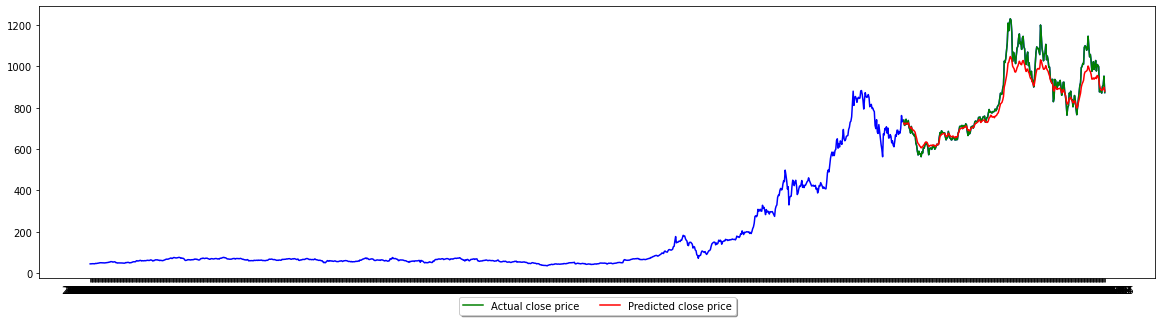

In [135]:
val = data[len(y_train)+1:]
val['pred'] = predictions1
plt.figure(figsize = (20,5))
plt.plot(data['close_price'], color = 'b')
plt.plot(val['close_price'], label = 'Actual close price', color = 'g')
plt.plot(val['pred'], label = 'Predicted close price', color = 'r')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()